In [3]:
!pip install pandas numpy matplotlib seaborn wordcloud scikit-learn nltk
!python -m nltk.downloader stopwords


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MultiLabelBinarizer
import re
import nltk
from nltk.corpus import stopwords

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [6]:
df = pd.read_csv('netflix_titles.csv')
print(df.shape)
display(df.head())
df.info()
df.describe(include='all').T


(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8807,8807,s8807,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8807,2,Movie,6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8807,8807,Zubaan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,6173,4528,Rajiv Chilaka,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,7982,7692,David Attenborough,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,7976,748,United States,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8797,1767,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8807.0,NaN,NaN,NaN,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8803,17,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8804,220,1 Season,1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')
df['added_year']  = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month_name()
df['added_month_num'] = df['date_added'].dt.month
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
for col in ['title','director','cast','country','rating','duration','listed_in','description']:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip()


In [8]:

df['duration_minutes'] = np.nan
df['duration_seasons'] = np.nan
def parse_duration(x):
    if pd.isna(x):
        return (np.nan, np.nan)
    x = str(x).strip()
    m = re.search(r'(\d+)\s*min', x, flags=re.IGNORECASE)
    if m:
        return (int(m.group(1)), np.nan)
    s = re.search(r'(\d+)\s*Season', x, flags=re.IGNORECASE)
    if s:
        return (np.nan, int(s.group(1)))
    return (np.nan, np.nan)

parsed = df['duration'].apply(parse_duration)
df['duration_minutes'] = parsed.map(lambda t: t[0])
df['duration_seasons'] = parsed.map(lambda t: t[1])


In [9]:
print("Missing values per column:\n", df.isna().sum())
display(df['type'].value_counts())
display(df['rating'].value_counts().head(30))


Missing values per column:
 show_id                0
type                   0
title                  0
director            2634
cast                 825
country              831
date_added            98
release_year           0
rating                 4
duration               3
listed_in              0
description            0
added_year            98
added_month           98
added_month_num       98
duration_minutes    2679
duration_seasons    6131
dtype: int64


,count
type,
Movie,6131
TV Show,2676


,count
rating,
TV-MA,3207
TV-14,2160
TV-PG,863
R,799
PG-13,490
TV-Y7,334
TV-Y,307
PG,287
TV-G,220


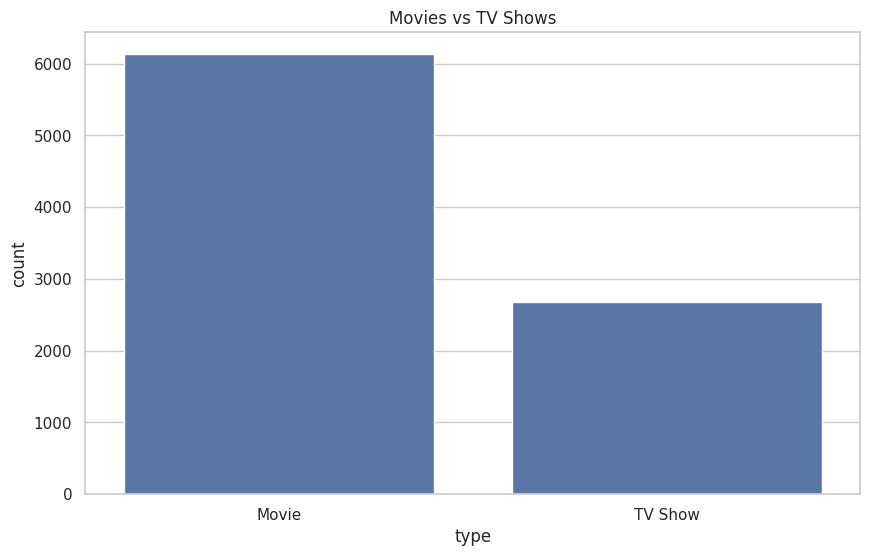

<Figure size 200x200 with 0 Axes>

In [32]:
sns.countplot(data=df, x='type')
plt.title('Movies vs TV Shows')
plt.figure(figsize=(2,2))
plt.show()


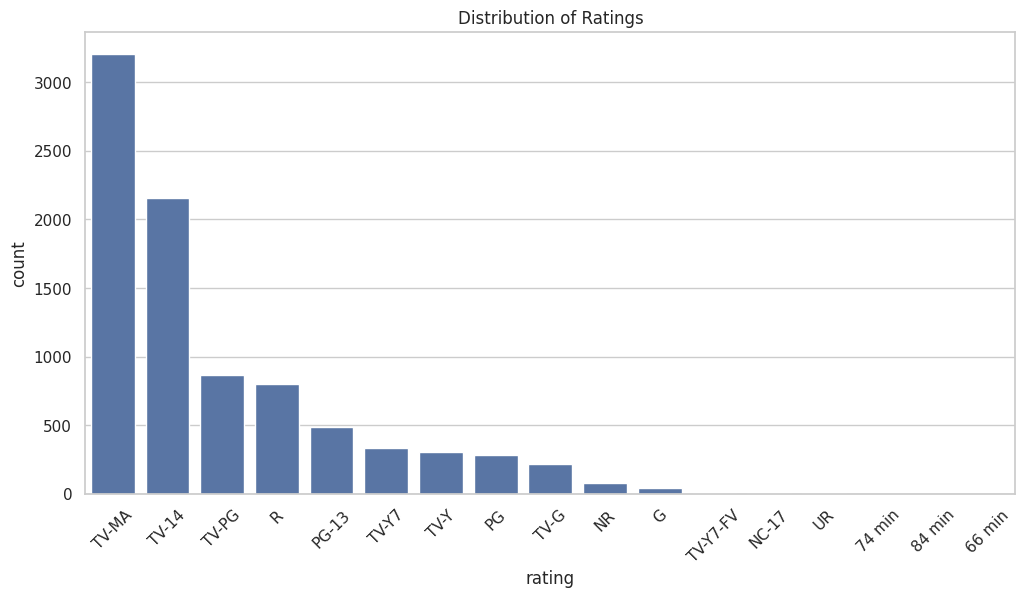

<Figure size 200x200 with 0 Axes>

In [33]:
plt.figure(figsize=(12,6))
order = df['rating'].value_counts().index
sns.countplot(data=df, x='rating', order=order)
plt.xticks(rotation=45)
plt.title('Distribution of Ratings')
plt.figure(figsize=(2,2))
plt.show()


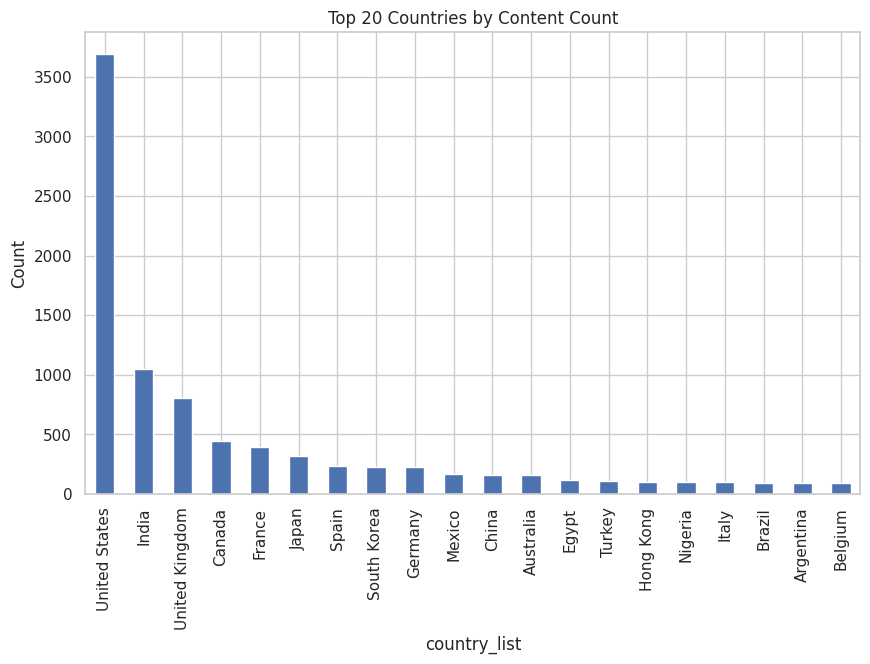

In [12]:
df_countries = (df[df['country'].notna()]
                .assign(country_list = df['country'].str.split(r',\s*'))
                .explode('country_list'))

top_countries = df_countries['country_list'].value_counts().head(20)
top_countries.plot(kind='bar')
plt.title('Top 20 Countries by Content Count')
plt.ylabel('Count')
plt.show()


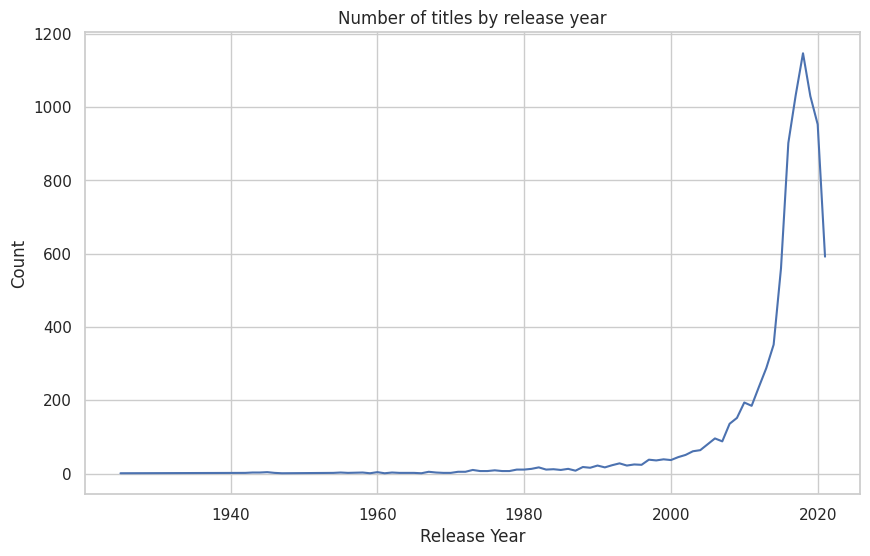

In [13]:
df['release_year'].dropna().astype(int).value_counts().sort_index().plot()
plt.title('Number of titles by release year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()


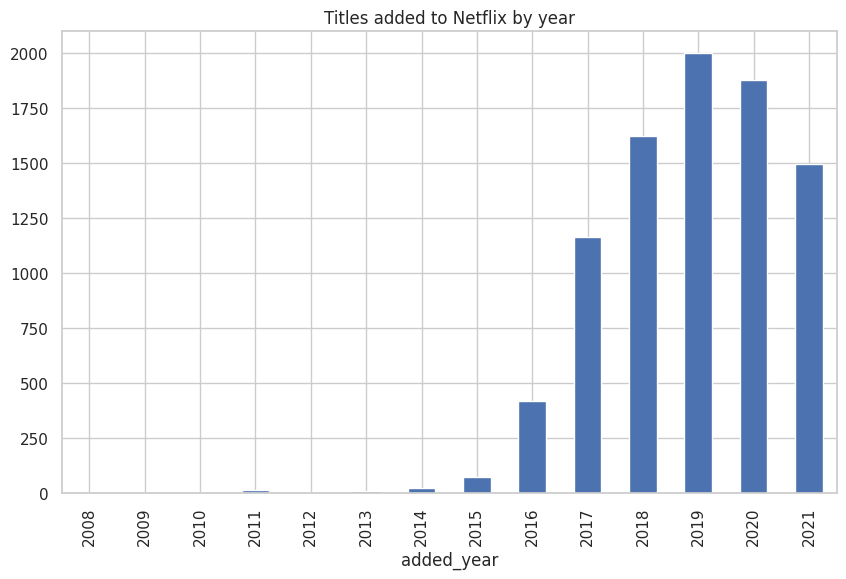

In [14]:
df['added_year'].dropna().astype(int).value_counts().sort_index().plot(kind='bar')
plt.title('Titles added to Netflix by year')
plt.show()


/tmp/ipython-input-3922962788.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cumulative = df_date_sorted.groupby(pd.Grouper(key='date_added', freq='M')).size().cumsum()


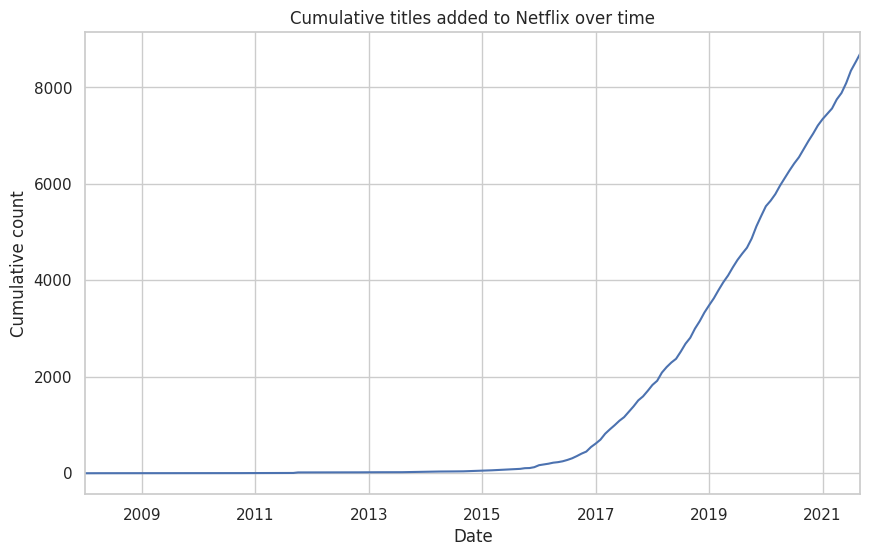

In [15]:
df_date_sorted = df.sort_values('date_added').dropna(subset=['date_added'])
cumulative = df_date_sorted.groupby(pd.Grouper(key='date_added', freq='M')).size().cumsum()
cumulative.plot()
plt.title('Cumulative titles added to Netflix over time')
plt.xlabel('Date')
plt.ylabel('Cumulative count')
plt.show()


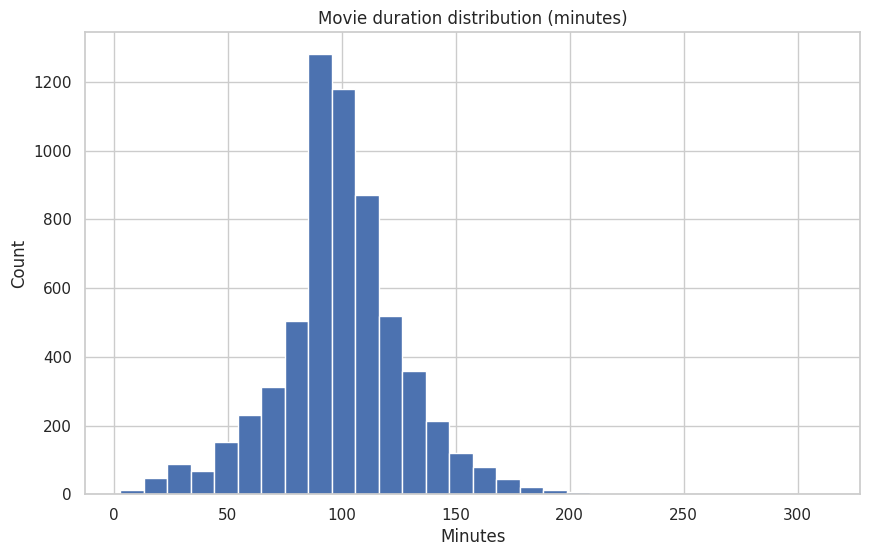

In [16]:
movie_minutes = df[df['type']=='Movie']['duration_minutes'].dropna().astype(int)
plt.hist(movie_minutes, bins=30)
plt.title('Movie duration distribution (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.show()


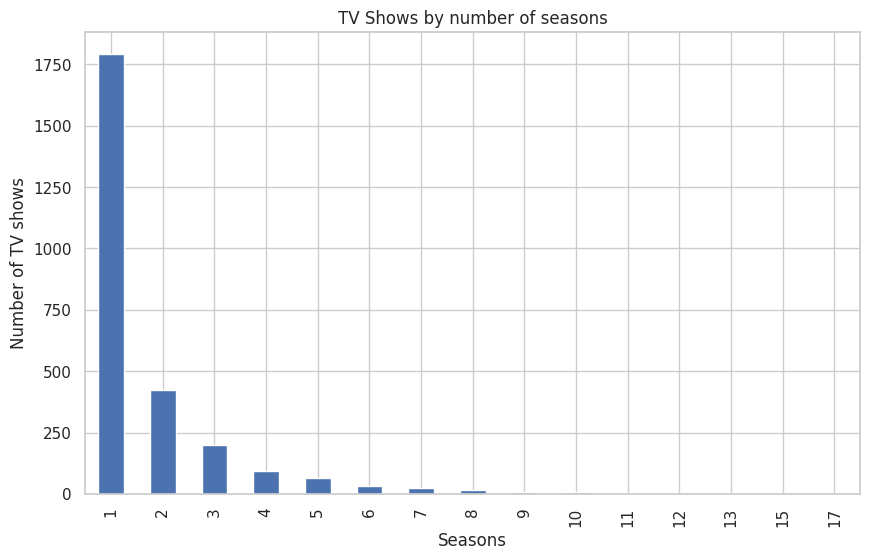

In [17]:
tv_seasons = df[df['type']=='TV Show']['duration_seasons'].dropna().astype(int)
tv_seasons.value_counts().sort_index().plot(kind='bar')
plt.title('TV Shows by number of seasons')
plt.xlabel('Seasons')
plt.ylabel('Number of TV shows')
plt.show()


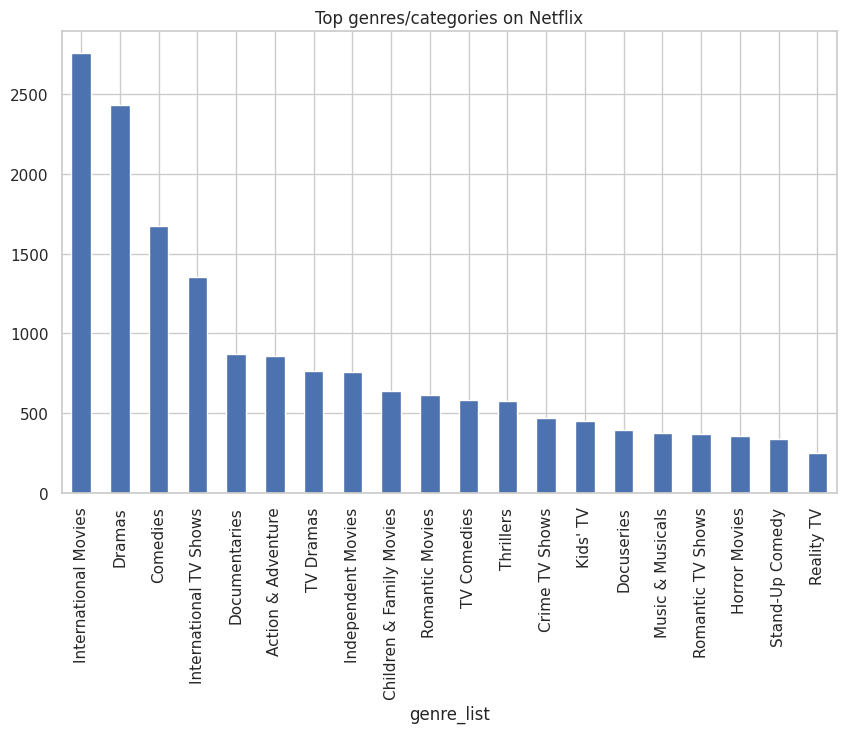

In [18]:
df_genres = df[df['listed_in'].notna()].assign(genre_list = df['listed_in'].str.split(r',\s*')).explode('genre_list')
top_genres = df_genres['genre_list'].value_counts().head(20)
top_genres.plot(kind='bar')
plt.title('Top genres/categories on Netflix')
plt.show()


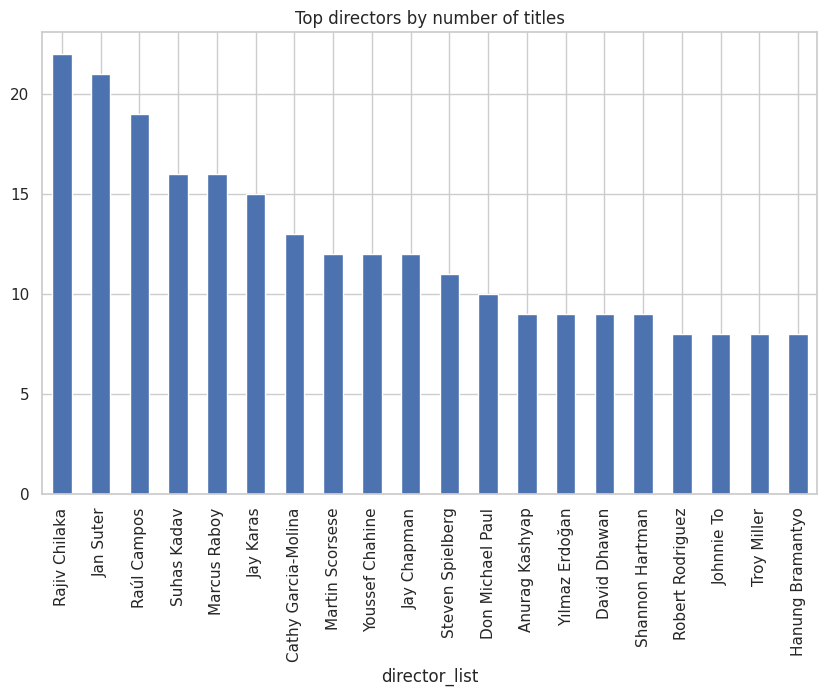

In [19]:
directors = (df[df['director'].notna()]
             .assign(director_list = df['director'].str.split(r',\s*'))
             .explode('director_list'))

directors_counts = directors['director_list'].value_counts().head(20)
directors_counts.plot(kind='bar')
plt.title('Top directors by number of titles')
plt.show()


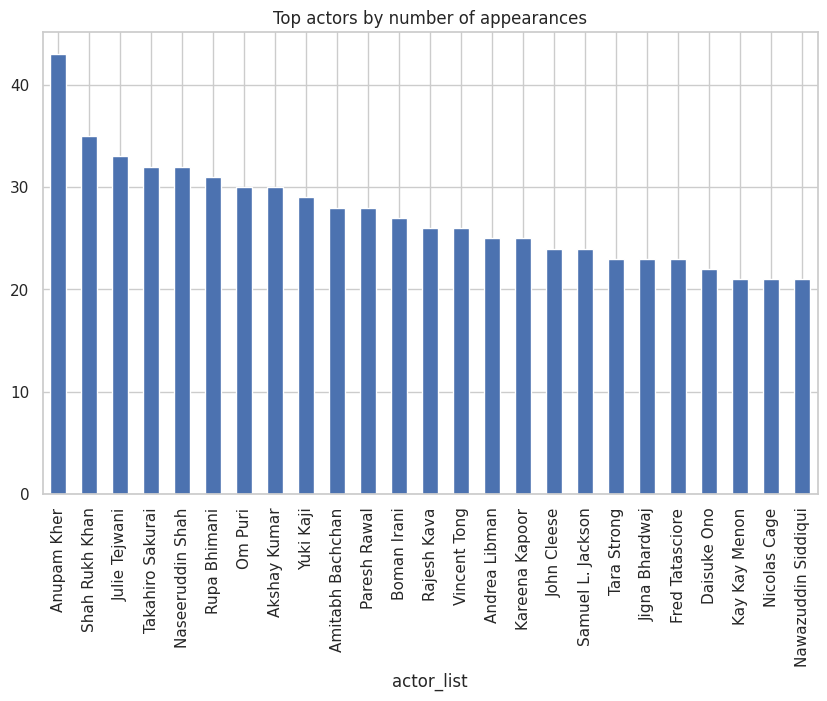

In [20]:
casts = (df[df['cast'].notna()]
         .assign(actor_list = df['cast'].str.split(r',\s*'))
         .explode('actor_list'))
casts['actor_list'].value_counts().head(25).plot(kind='bar')
plt.title('Top actors by number of appearances')
plt.show()


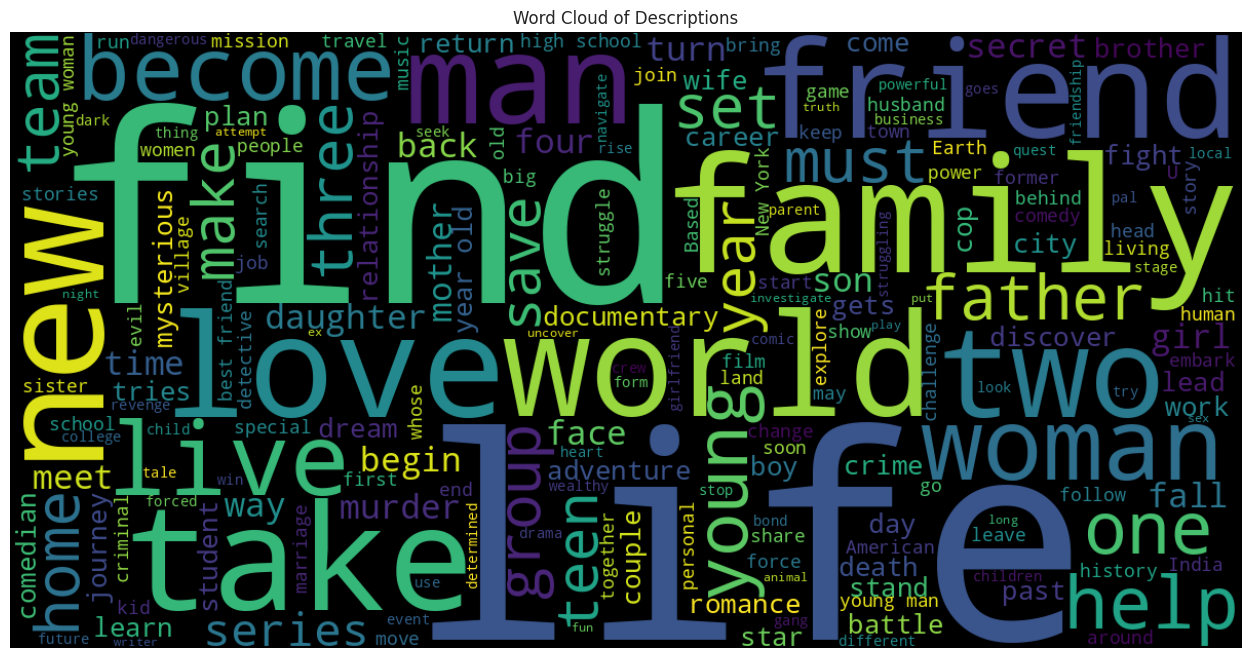

<Figure size 200x200 with 0 Axes>

In [34]:
text = " ".join(df['description'].dropna().astype(str).tolist())
stop = set(STOPWORDS).union(set(stopwords.words('english')))
wc = WordCloud(width=1200, height=600, stopwords=stop).generate(text)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=50)
bag = cv.fit_transform(df['description'].dropna().astype(str))
pd.Series(bag.toarray().sum(axis=0), index=cv.get_feature_names_out()).sort_values(ascending=False)


,0
life,845
young,729
new,709
family,635
world,570
man,538
love,504
woman,486
friends,445
series,396


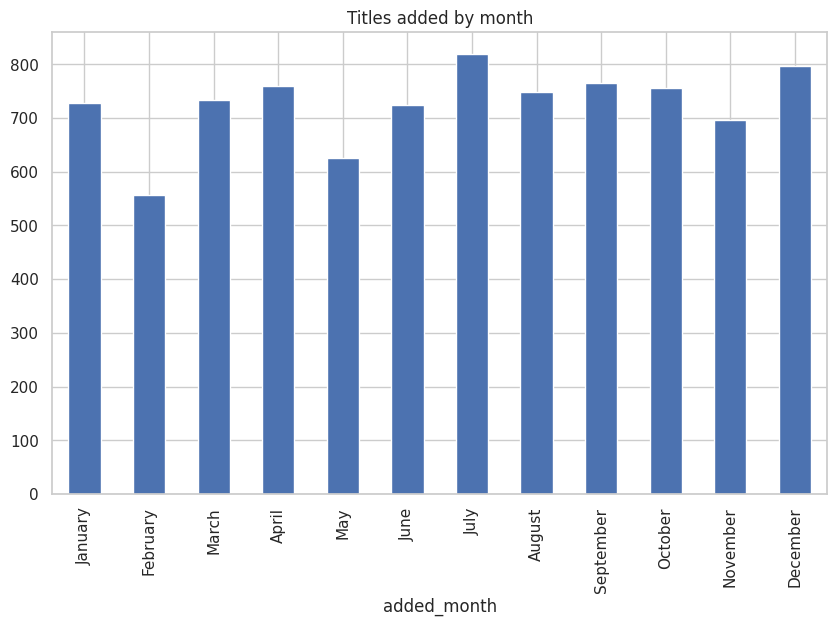

In [23]:
df['added_month'] = df['date_added'].dt.month_name()
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
added_by_month = df['added_month'].value_counts().reindex(month_order).dropna()
added_by_month.plot(kind='bar')
plt.title('Titles added by month')
plt.show()


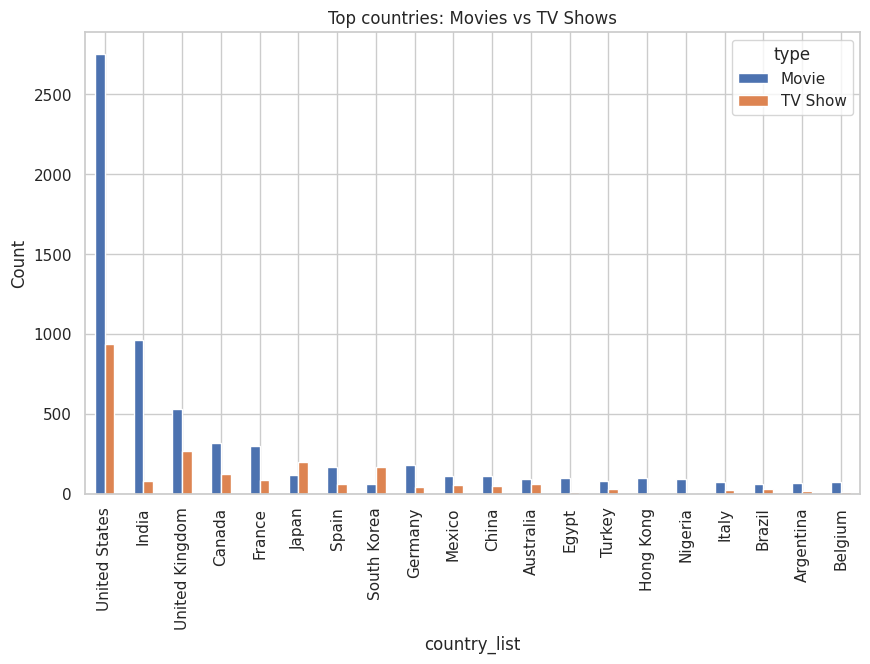

type,Movie,TV Show,movie_to_tv_ratio
country_list,,,
South Korea,61,170,0.358824
Japan,119,199,0.597990
Australia,94,66,1.424242
Mexico,111,58,1.913793
United Kingdom,534,272,1.963235
Brazil,66,31,2.129032
China,114,48,2.375000
Canada,319,126,2.531746
Turkey,83,30,2.766667


In [24]:

country_type = (df[df['country'].notna()]
                .assign(country_list = df['country'].str.split(r',\s*'))
                .explode('country_list')
                .groupby(['country_list','type']).size().unstack(fill_value=0))
country_type['total'] = country_type.sum(axis=1)
top = country_type.sort_values('total', ascending=False).head(20).drop(columns='total')
top.plot(kind='bar', stacked=False)
plt.title('Top countries: Movies vs TV Shows')
plt.ylabel('Count')
plt.show()
top['movie_to_tv_ratio'] = top.get('Movie',0).astype(int).div(top.get('TV Show',0).replace(0, np.nan))
display(top.sort_values('movie_to_tv_ratio', na_position='last').head(10))


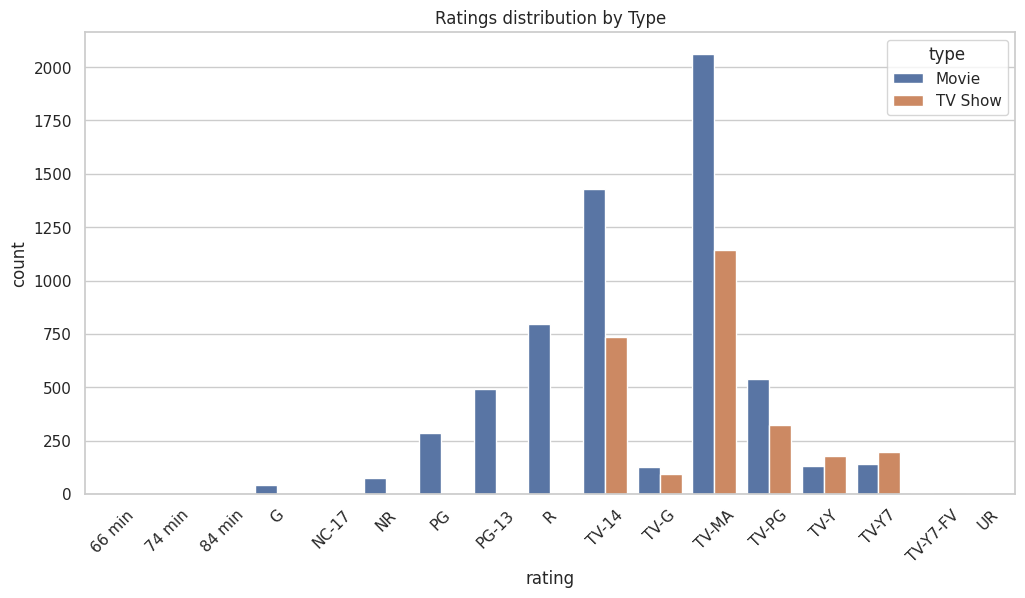

In [25]:
rating_by_type = df.groupby(['type','rating']).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.barplot(data=rating_by_type, x='rating', y='count', hue='type')
plt.xticks(rotation=45)
plt.title('Ratings distribution by Type')
plt.show()


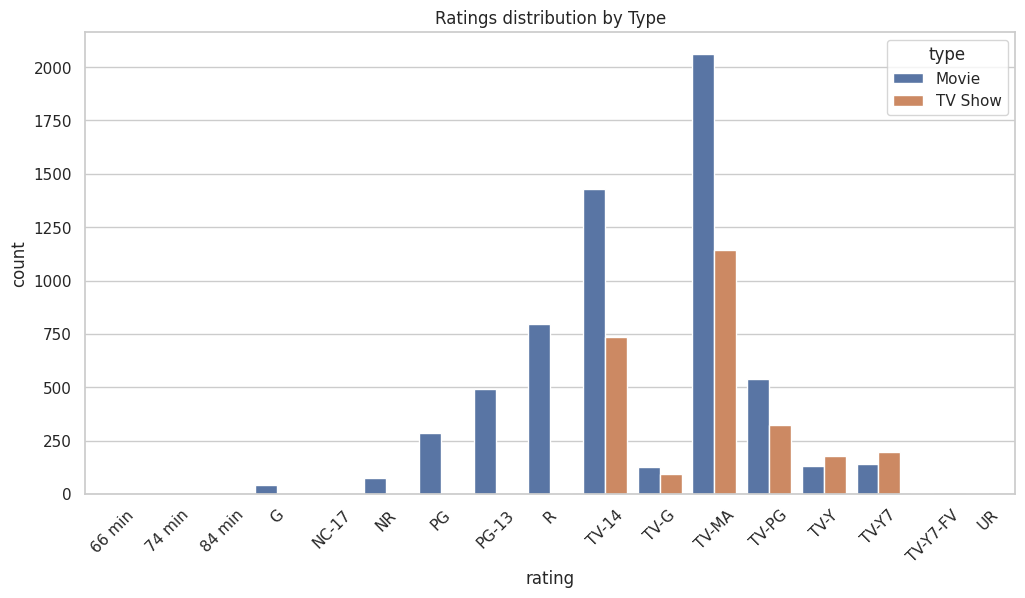

In [26]:
rating_by_type = df.groupby(['type','rating']).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.barplot(data=rating_by_type, x='rating', y='count', hue='type')
plt.xticks(rotation=45)
plt.title('Ratings distribution by Type')
plt.show()


In [27]:

oldest = df.loc[df['release_year'].idxmin()]
newest = df.loc[df['release_year'].idxmax()]
print("Oldest title(s):")
display(df[df['release_year']==df['release_year'].min()][['title','release_year','type']].head())
print("Newest title(s):")
display(df[df['release_year']==df['release_year'].max()][['title','release_year','type']].head())
display(df.sort_values('date_added', ascending=False)[['title','date_added','type']].head(10))


Oldest title(s):


,title,release_year,type
4250,Pioneers: First Women Filmmakers*,1925,TV Show


Newest title(s):


,title,release_year,type
1,Blood & Water,2021,TV Show
2,Ganglands,2021,TV Show
3,Jailbirds New Orleans,2021,TV Show
4,Kota Factory,2021,TV Show
5,Midnight Mass,2021,TV Show


,title,date_added,type
0,Dick Johnson Is Dead,2021-09-25,Movie
6,My Little Pony: A New Generation,2021-09-24,Movie
10,"Vendetta: Truth, Lies and The Mafia",2021-09-24,TV Show
9,The Starling,2021-09-24,Movie
8,The Great British Baking Show,2021-09-24,TV Show
7,Sankofa,2021-09-24,Movie
1,Blood & Water,2021-09-24,TV Show
5,Midnight Mass,2021-09-24,TV Show
3,Jailbirds New Orleans,2021-09-24,TV Show
2,Ganglands,2021-09-24,TV Show


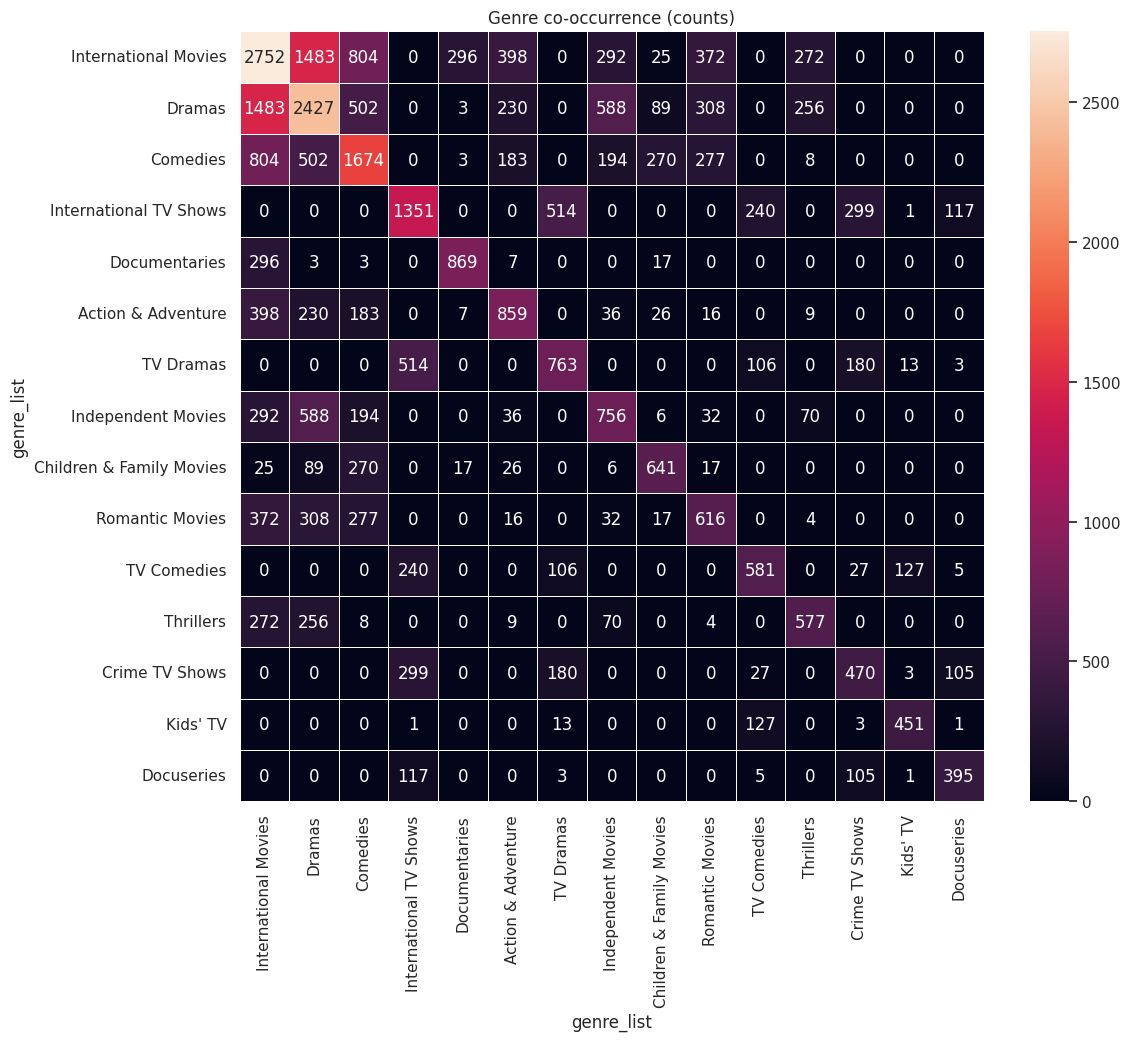

In [28]:

df['genre_list'] = df['listed_in'].fillna('').str.split(r',\s*')
mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_, index=df.index)
cooccurrence = genre_matrix.T.dot(genre_matrix)
diag = np.diag(cooccurrence)
norm = cooccurrence / diag[:,None]
top_genres_list = top_genres.index[:15]
heat = cooccurrence.loc[top_genres_list, top_genres_list]
plt.figure(figsize=(12,10))
sns.heatmap(heat, annot=True, fmt='d', linewidths=.5)
plt.title('Genre co-occurrence (counts)')
plt.show()


In [29]:
df.to_csv('netflix_titles_processed.csv', index=False)

